
# Explainable Reinforcement Learning in Finance — SAC Demo

<img src="https://res.cloudinary.com/springboard-images/image/upload/w_1080,c_limit,q_auto,f_auto,fl_lossy/wordpress/2021/10/shutterstock_1053717473-scaled.jpg" alt="diagram" width="100" style="display:block; margin:auto;">

This notebook trains a **Soft Actor-Critic (SAC)** policy for a toy **daily portfolio allocation** task,
then distills the policy into a **small decision tree** and uses **SHAP** (on the student tree) for fast, readable explanations.

### Content
- A minimal **portfolio environment** (Gymnasium-compatible).
- **Data** pulled with `stooq` (with an offline synthetic fallback).
- **Train** a SAC agent (short wall-clock) on train period; evaluate on test.
- **Distill** the teacher policy to a small decision tree (depth≈3).
- **Explain** the distilled policy with SHAP (feature importances and per-period contributions).
- **Compare** performance and **fidelity** (student vs teacher actions).

Wouter van Heeswijk <br>
MSCA DIGITAL Training Week on Explainable AI in Finance <br>
BFH, Bern, 9.10.2025

# Setup and Imports

This cell prepares the Python environment for the tutorial.

---

### 1. Optional installations
- The commented `%pip install` line lists all required packages if running in a fresh environment.
- Some packages (e.g., `gymnasium`, `stable-baselines3`, `shap`) may take a few minutes to install.

### 2. Standard library imports
- `warnings`, `os`, `math`, `sys`, `time`, `random` for general utilities.

### 3. Numerical and data handling
- `numpy` and `pandas` for array and table manipulations.
- `matplotlib.pyplot` for plotting.
- Default figure size is set for consistency across environments.

### 4. Optional third-party libraries
- `stooq`: download financial data (fallback to None if missing).
- `gymnasium` / `gym`: reinforcement learning environments.
- `stable_baselines3`: RL algorithms like SAC.
- `shap`: interpretable ML and feature attribution.
- Imports are wrapped in `try/except` so the notebook can still run if some packages are missing.

### 5. Scikit-learn imports
- `DecisionTreeRegressor` and `export_text` for interpretable tree models.
- `mean_absolute_error` to evaluate model fidelity.

### 6. Random seeds
- Fix random seeds for `random` and `numpy` for reproducibility

In [1]:
%pip install --quiet pandas numpy matplotlib scikit-learn gymnasium shimmy==0.2.1 stable-baselines3==2.3.2 torch shap



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings, os, math, sys, time, random
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:

# If running on a fresh environment, uncomment these lines.
# They are commented to avoid long installs during quick reads.
# Note: gymnasium, stable-baselines3, and shap may take a few minutes to install.
# %pip install --quiet yfinance pandas numpy matplotlib scikit-learn gymnasium shimmy==0.2.1 stable-baselines3==2.3.2 torch shap



# Matplotlib policy for tutorial: no styles or explicit colors (keeps it consistent across environments).
plt.rcParams.update({'figure.figsize': (8, 4)})

# Try imports that may not be present in all environments
try:
    import yfinance as yf
except Exception as e:
    yf = None

try:
    import gymnasium as gym
except Exception as e:
    import gym  # fallback if gymnasium not available (older gym)
    gym.logger.set_level(40)

try:
    from stable_baselines3 import SAC
    from stable_baselines3.common.vec_env import DummyVecEnv
    from stable_baselines3.common.monitor import Monitor
    from stable_baselines3.common.utils import set_random_seed
except Exception as e:
    SAC = None

from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_absolute_error
try:
    import shap
except Exception:
    shap = None

SEED = 42
random.seed(SEED); np.random.seed(SEED)


2025-10-09 16:47:16.441415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-09 16:47:16.441447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-09 16:47:16.443919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-09 16:47:17.308804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-09 16:47:23.934396: W tensorflow/compiler/

# Fetch or Generate Financial Data

This cell handles obtaining historical financial data for the selected assets.

---

### 1. Assets and Date Range
- `TICKERS = ["SPY", "IEF", "GLD"]` specifies the assets:
  - **SPY**: equities
  - **IEF**: US Treasuries
  - **GLD**: gold
  - **BTCUSD**: Bitcoin
- `START` and `END` define the historical period for analysis (`2012-01-01` to `2024-12-31`).

### 2. `fetch_data()` function
- Downloads adjusted close prices using `stooq`.
- Handles errors gracefully:
  - If `stooq` is not installed, uses synthetic data.
  - If the download fails or returns empty data, falls back to synthetic data.
- Ensures the returned DataFrame is well-formed, with one column per asset and business-day index.

### 3. `synthetic_data()` function
- Generates geometric random walks for each asset as a fallback.
- Simulates realistic daily returns and volatility.
- Creates a DataFrame indexed by business days with columns `A0, A1, …` for each asset.

### 4. Output
- `prices = fetch_data()` fetches or generates the data.
- `prices.head()` displays the first few rows for inspection.


In [4]:


TICKERS = ["XOM", "TSLA", "JPM", "IEF", "GLD", ]  # equities, treasuries, gold
START, END = "2015-12-01", "2024-12-31"
DATA_FILE = "prices_snapshot.csv"


def download_stooq(tickers):
    """
    Download daily historical stock data from Stooq.com for multiple tickers.
    Returns combined DataFrame with tickers as columns and dates as index.
    """
    all_data = []

    for ticker in tickers:
        url = f"https://stooq.com/q/d/l/?s={ticker.lower()}.us&i=d"
        try:
            df = pd.read_csv(url)
        except Exception as e:
            print(f"Failed to download {ticker}: {e}")
            continue

        # Find 'Date' column
        date_col = next((c for c in df.columns if c.lower() == "date"), None)
        if date_col is None:
            print(f"No date column for {ticker}, skipping")
            continue

        # Parse dates
        df[date_col] = pd.to_datetime(df[date_col])
        df.set_index(date_col, inplace=True)

        # Keep only 'Close' price
        close_col = next((c for c in df.columns if c.lower() == "close"), None)
        if close_col is None:
            print(f"No close column for {ticker}, skipping")
            continue

        df = df[[close_col]].rename(columns={close_col: ticker.upper()})
        # Filter by date range
        df = df.loc[(df.index >= START) & (df.index <= END)]
        all_data.append(df)

    if not all_data:
        raise ValueError("No data downloaded for any tickers.")

    combined = pd.concat(all_data, axis=1)
    return combined


def fetch_data(tickers=TICKERS, file=DATA_FILE, max_retries=3, delay=2):
    """
    Fetch daily price data with caching, Stooq download, and synthetic fallback.
    """
    # --- Load from CSV if exists ---
    if os.path.exists(file):
        print(f"Loading data from local file: {file}")
        return pd.read_csv(file, index_col=0, parse_dates=True)

    retries = 0
    while retries < max_retries:
        try:
            print(f"Downloading data for {tickers} from Stooq...")
            df = download_stooq(tickers)
            if df.empty:
                raise ValueError("Downloaded data is empty")
            # Save snapshot
            df.to_csv(file)
            print(f"Data saved locally to {file}")
            return df
        except Exception as e:
            retries += 1
            print(f"Download failed (attempt {retries}/{max_retries}): {e}")
            time.sleep(delay)

    print("All download attempts failed — using synthetic fallback.")
    return synthetic_data(len(tickers))


def synthetic_data(n_assets=3, n_days=1000):
    idx = pd.date_range(START, periods=n_days, freq="B")
    prices = []
    for i in range(n_assets):
        trend = 0.05 + 0.02 * np.random.rand()
        volatility = 0.1 + 0.05 * np.random.rand()
        shock = np.random.normal(0, volatility / np.sqrt(252), size=n_days)
        path = 100 * np.exp(np.cumsum(trend / 252 + shock))
        prices.append(path)
    df = pd.DataFrame(np.vstack(prices).T, index=idx, columns=[f"A{i}" for i in range(n_assets)])
    return df


# --- Usage ---
prices = fetch_data()
print(prices.head())


Loading data from local file: prices_snapshot.csv
                XOM      IEF     GLD     TSLA
Date                                         
2015-12-01  58.5878  96.9267  102.28  15.8127
2015-12-02  56.9120  96.6438  100.69  15.4660
2015-12-03  56.0961  95.6795  101.76  15.5140
2015-12-04  56.4190  96.0182  104.02  15.3587
2015-12-07  54.9446  96.3190  102.67  15.4087


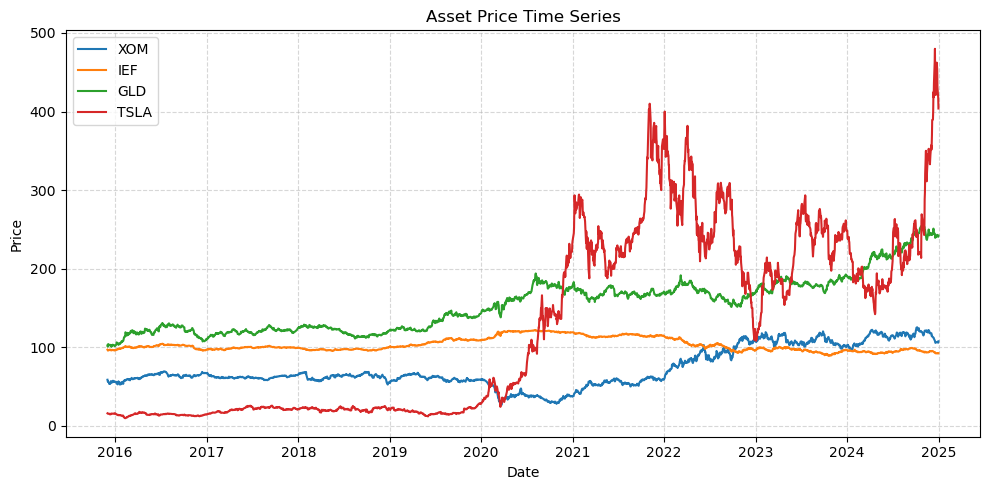

In [5]:

def plot_prices(df, title="Asset Price Time Series"):
    # Always wrap into DataFrame
    if isinstance(df, pd.Series):
        df = df.to_frame(name=df.name or "Price")
    elif not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    plt.figure(figsize=(10, 5))
    for col in df.columns:
        plt.plot(df.index.to_numpy(), df[col].to_numpy(), label=str(col))
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()



# Example usage:
plot_prices(prices)


# Feature Engineering

This cell creates input features for the RL/ML models based on historical price data.

We compute daily returns and several rolling features for each asset:

- **`ret_1`**: previous day return
- **`mom_20`**: 20-day momentum (percentage change over the last 20 days)
- **`vol_20`**: 20-day rolling volatility (standard deviation of returns)
- **`dd_60`**: 60-day drawdown relative to rolling maximum

All features are combined into a single DataFrame with descriptive column names of the form `Asset_Feature` (e.g., `SPY_mom_20`). Rows with missing values are dropped.

We also compute **forward returns** for reward calculation:

```python
fwd_rets = price_df.pct_change().shift(-1).reindex(feat_df.index).fillna(0.0)


In [6]:

def make_features(price_df: pd.DataFrame):
    rets = price_df.pct_change().fillna(0.0)
    # Simple rolling features per asset
    feats = {}
    for col in price_df.columns:
        r = rets[col]
        feats[(col, "ret_1")] = r
        feats[(col, "mom_20")] = (price_df[col] / price_df[col].shift(20) - 1.0).fillna(0.0)
        feats[(col, "vol_20")] = r.rolling(20).std().fillna(0.0)
        feats[(col, "dd_60")] = (price_df[col] / price_df[col].rolling(60).max() - 1.0).fillna(0.0)
    feat_df = pd.DataFrame(feats)
    feat_df.columns = [f"{a}_{n}" for (a,n) in feat_df.columns]
    feat_df = feat_df.dropna()
    # Align returns for portfolio reward (next day return)
    fwd_rets = price_df.pct_change().shift(-1).reindex(feat_df.index).fillna(0.0)
    return feat_df, fwd_rets

feat_df, fwd_rets = make_features(prices)
feat_df.tail(3)


,XOM_ret_1,XOM_mom_20,XOM_vol_20,XOM_dd_60,IEF_ret_1,IEF_mom_20,IEF_vol_20,IEF_dd_60,GLD_ret_1,GLD_mom_20,GLD_vol_20,GLD_dd_60,TSLA_ret_1,TSLA_mom_20,TSLA_vol_20,TSLA_dd_60
Date,,,,,,,,,,,,,,,,
2024-12-27,-0.000094,-0.095020,0.008696,-0.150674,-0.002600,-0.028590,0.003708,-0.054717,-0.006870,-0.008584,0.009056,-0.062524,-0.049479,0.296705,0.040771,-0.100446
2024-12-30,-0.006762,-0.103425,0.008521,-0.156417,0.005864,-0.026999,0.003855,-0.039909,-0.003190,-0.020196,0.008820,-0.065515,-0.033012,0.209323,0.041680,-0.130142
2024-12-31,0.017114,-0.087230,0.009869,-0.141980,-0.001835,-0.025714,0.003834,-0.040278,0.006234,-0.005381,0.008761,-0.059689,-0.032510,0.130919,0.042325,-0.158421


# Portfolio Environment Definition

This cell defines the reinforcement learning environment for portfolio allocation.

---

### 1. `EnvConfig` Dataclass
- Holds configuration parameters for the environment:
  - `transaction_cost`: cost per unit turnover (default `0.0002`)
  - `risk_penalty`: multiplier for risk term in reward (default `2.0`)
  - `max_weight`: maximum allocation to risky assets (cash = 1 - sum of risky weights)
  - `window`: context window size (currently 1, can be extended for multi-step state)

### 2. `PortfolioEnv` Class
- Inherits from `gym.Env`.
- **Observations**: flattened features for all assets (size = `obs_dim`).
- **Actions**: logits for each risky asset; cash allocation is implicit.
- **Action Space**: continuous Box in `[-1, 1]^N`.
- **Observation Space**: continuous Box in `[-inf, inf]^obs_dim`.

### 3. `reset()`
- Initializes the environment:
  - Time step `_t = 0`
  - Risky weights `_w = 0`
  - Equity `_eq = 1.0`
- Returns the first observation.

### 4. `step(action)`
- Converts action logits into valid portfolio weights via softmax (including cash).
- Caps total risky weight by `max_weight`.
- Computes transaction cost from weight changes.
- Realizes next-day portfolio return using risky asset returns; cash earns 0.
- Applies simple risk penalty (variance proxy using squared return).
- Updates equity and internal state.
- Returns: `(observation, reward, terminated, truncated, info)`

### 5. `render()`
- Prints the current time step, portfolio equity, and risky asset weights for inspection.


In [7]:

@dataclass
class EnvConfig:
    transaction_cost: float = 0.0002  # per unit turnover
    risk_penalty: float = 2.0         # * variance estimate
    max_weight: float = 0.95          # cap on risky allocation (cash = 1 - sum)
    window: int = 1                   # single-step state (you can extend to use past windows)

class PortfolioEnv(gym.Env):
    metadata = {"render.modes": ["human"]}
    def __init__(self, features: pd.DataFrame, fwd_returns: pd.DataFrame, cfg: EnvConfig):
        super().__init__()
        assert features.index.equals(fwd_returns.index)
        self.features = features.values.astype(np.float32)
        self.fwd = fwd_returns.values.astype(np.float32)  # shape [T, N]
        self.dates = fwd_returns.index
        self.T, self.N = self.fwd.shape
        self.cfg = cfg
        # Observation: flattened features for all assets (can be extended)
        self.obs_dim = self.features.shape[1]
        # Action: logits for N assets (cash implied)
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(self.N,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)
        self._t = None
        self._w = np.zeros(self.N, dtype=np.float32)  # current risky weights
        self._eq = 1.0

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self._t = 0
        self._w[:] = 0.0
        self._eq = 1.0
        return self._obs(), {}

    def _obs(self):
        # Single-step features; could stack windows for more context
        return self.features[self._t]

    def step(self, action):
        # Convert action (logits in [-1,1]) to valid weights via softmax including cash baseline
        logits = np.clip(action, -5, 5).astype(np.float32)
        # Add a fixed zero logit for cash so student can choose cash when nothing stands out
        all_logits = np.concatenate([logits, [0.0]]).astype(np.float32)  # length N+1
        w_all = np.exp(all_logits - np.max(all_logits))
        w_all = w_all / w_all.sum()
        w_risky = w_all[:-1]
        # Cap total risky weight
        risky_sum = w_risky.sum()
        if risky_sum > self.cfg.max_weight:
            w_risky = w_risky * (self.cfg.max_weight / risky_sum)
        # Compute turnover cost
        turnover = np.abs(w_risky - self._w).sum()
        cost = self.cfg.transaction_cost * turnover

        # Realize next-day portfolio return from risky legs; cash earns 0 in this toy
        r = (w_risky * self.fwd[self._t]).sum()

        # Simple risk proxy: variance from recent window (use instantaneous squared return here)
        risk = (r**2)

        reward = r - cost - self.cfg.risk_penalty * risk
        self._eq *= (1.0 + r - cost)
        self._w = w_risky
        self._t += 1
        terminated = (self._t >= self.T - 1)
        truncated = False
        info = {"equity": self._eq, "return": r, "cost": cost}
        obs = self._obs() if not terminated else np.zeros_like(self._obs())
        return obs, float(reward), terminated, truncated, info

    def render(self):
        print(f"t={self._t}, eq={self._eq:.3f}, w={self._w}")


# Train/Test Split and Environment Setup

This cell prepares the training and testing environments for reinforcement learning.

We perform the following steps:

1. **Train/Test Split**  
   - Split the feature matrix (`feat_df`) and forward returns (`fwd_rets`) into training and test sets using an 80/20 split.

2. **Environment Configuration**  
   - Create an instance of `EnvConfig()` to hold hyperparameters such as transaction cost, risk penalty, and maximum risky allocation.

3. **Environment Instances**  
   - Initialize `PortfolioEnv` for training and testing with the corresponding features and forward returns.

4. **Vectorized Environment for Stable-Baselines3**  
   - Wraps the environment in `Monitor` and `DummyVecEnv` for compatibility with SB3 algorithms.  
   - Provides a message if SB3 is not installed.

Outputs:  
- `train_env`, `test_env`: raw environment instances  
- `vec_train`: vectorized training environment (if SB3 is available)


In [8]:

split_idx = int(0.8 * len(feat_df))
train_feats, test_feats = feat_df.iloc[:split_idx], feat_df.iloc[split_idx:]
train_fwd, test_fwd = fwd_rets.iloc[:split_idx], fwd_rets.iloc[split_idx:]

cfg = EnvConfig()

train_env = PortfolioEnv(train_feats, train_fwd, cfg)
test_env  = PortfolioEnv(test_feats,  test_fwd,  cfg)

def make_vec(env):
    # Wrap in Monitor and DummyVecEnv for SB3
    def _thunk():
        return Monitor(env)
    return DummyVecEnv([_thunk])

if SAC is None:
    print("Stable-Baselines3 not available. Please install it to train the RL agent.")
vec_train = make_vec(train_env) if SAC is not None else None


# Train the RL Agent (SAC)

This cell trains a reinforcement learning agent using the Soft Actor-Critic (SAC) algorithm.

---

### 1. Training Configuration
- `total_timesteps = 30_000`: modest number of steps for a live demo; can be increased for more thorough training.

### 2. Model Initialization
- Checks if Stable-Baselines3 (SAC) is available.
- Sets a fixed random seed for reproducibility.
- Creates a SAC agent with `MlpPolicy` using the vectorized training environment `vec_train`.

### 3. Model Training
- Calls `model.learn()` to train the agent for the specified timesteps.
- Measures and prints training duration.

### 4. Fallback
- If SAC is not available, `model` is set to `None` and the notebook can still proceed with alternative policies.


In [9]:

total_timesteps = 5_000  # keep modest for live demo; tune as needed
if SAC is not None:
    set_random_seed(SEED)
    model = SAC("MlpPolicy", vec_train, verbose=0, seed=SEED, tensorboard_log=None)
    start = time.time()
    model.learn(total_timesteps=total_timesteps, progress_bar=False)
    print(f"Training finished in {time.time() - start:.1f}s")
else:
    model = None


Training finished in 49.9s


# Policy Rollout Functions

This cell defines functions to simulate policies in the portfolio environment.

---

### 1. `rollout_policy(env, policy_fn)`
- Runs a given policy in the environment and logs portfolio weights, returns, and equity.
- Steps:
  1. Reset the environment.
  2. At each timestep, call `policy_fn(obs)` to get raw action logits.
  3. Convert logits to valid weights (softmax including cash baseline).
  4. Step the environment and store:
     - Risky weights (`Ws`)
     - Instantaneous returns (`R`)
     - Cumulative equity (`EQ`)
     - Dates
  5. Stop when the episode ends.
- Returns:
  - `Ws`: DataFrame of weights per asset
  - `R`: Series of returns
  - `EQ`: Series of cumulative equity

### 2. `sac_policy_fn(model)`
- Wraps a trained SAC model to produce deterministic actions from observations.
- Ensures outputs are correctly shaped for `rollout_policy`.

### 3. `cash_only_policy(env)`
- Simple baseline policy that always chooses cash (all-zero logits).
- Useful for fallback or baseline comparisons.


In [10]:

def rollout_policy(env: PortfolioEnv, policy_fn):
    obs, _ = env.reset()
    Ws, R, EQ, dates = [], [], [], []
    done = False
    while not done:
        a = policy_fn(obs)
        # Same mapping to weights used in env (so we can log weights)
        logits = np.clip(a, -5, 5).astype(np.float32)
        all_logits = np.concatenate([logits, [0.0]]).astype(np.float32)
        w_all = np.exp(all_logits - np.max(all_logits))
        w_all = w_all / w_all.sum()
        w_risky = w_all[:-1]
        obs, reward, term, trunc, info = env.step(a)
        Ws.append(w_risky.copy())
        R.append(info["return"])
        EQ.append(info["equity"])
        dates.append(env.dates[env._t-1])
        done = term or trunc
    return pd.DataFrame(Ws, index=dates, columns=[f"W_{c}" for c in range(env.N)]), \
           pd.Series(R, index=dates, name="return"), \
           pd.Series(EQ, index=dates, name="equity")

def sac_policy_fn(model):
    def fn(obs):
        a, _ = model.predict(obs, deterministic=True)
        return a[0] if isinstance(a, (list, tuple, np.ndarray)) and a.ndim>1 else a
    return fn

def cash_only_policy(env):
    def fn(obs):  # zero logits => mostly cash
        return np.zeros(env.N, dtype=np.float32)
    return fn


# Teacher Policy Rollout and Test Equity

This cell runs the “teacher” policy (trained SAC agent) on the test environment and visualizes its performance.

---

### 1. Teacher Rollout
- If a SAC model was trained, `rollout_policy` simulates it on `test_env`.
- If no model is available, a trivial baseline (`cash_only_policy`) is used instead.
- Outputs:
  - `W_teach`: DataFrame of asset weights over time
  - `R_teach`: Series of realized returns
  - `EQ_teach`: Series of cumulative equity

### 2. Equity Curve Plot
- Visualizes cumulative portfolio equity over the test period to show performance.
- X-axis: Dates  
- Y-axis: Portfolio equity

### 3. Inspect Last Weights
- `W_teach.tail()` shows the last few days of asset allocations for reference.


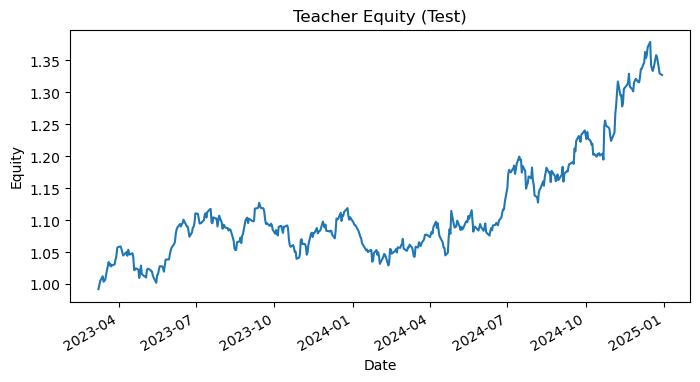

,W_0,W_1,W_2,W_3
2024-12-23,0.193885,0.190760,0.218843,0.196525
2024-12-24,0.197725,0.192812,0.203959,0.206246
2024-12-26,0.193802,0.190649,0.217871,0.198027
2024-12-27,0.191295,0.189169,0.226113,0.193465
2024-12-30,0.192734,0.190015,0.222764,0.194399


In [11]:

if model is not None:
    W_teach, R_teach, EQ_teach = rollout_policy(test_env, sac_policy_fn(model))
else:
    print("No SAC model; using a trivial baseline as placeholder.")
    W_teach, R_teach, EQ_teach = rollout_policy(test_env, cash_only_policy(test_env))

# Plot equity curve
plt.figure()
EQ_teach.plot()
plt.title("Teacher Equity (Test)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.show()

W_teach.tail()


# Student Policy via Decision Tree Imitation

This cell builds an interpretable student policy by imitating the teacher (SAC) actions using a shallow decision tree.

---

### 1. Prepare Training Dataset
- Rollout the teacher policy on the training environment:
  - `W_train_teacher`: asset weights chosen by the teacher
- Align features (`train_feats`) with teacher actions.
- `X_train`: features for the tree  
- `Y_train`: target weights from the teacher

### 2. Fit Student Decision Tree
- `DecisionTreeRegressor(max_depth=3)` is used for interpretability.
- Fits `X_train` → `Y_train`.
- Fidelity on the training set (MAE of weights vs. teacher) is printed.

### 3. Define Tree Policy Function
- Converts tree-predicted weights to logits for the environment.
- Ensures valid probabilities via clipping and log transformation.
- Cash baseline is included as zero logit.

### 4. Rollout Student on Test Environment
- `rollout_policy(test_env, tree_policy_fn)` produces:
  - `W_student`: student weights
  - `R_student`: realized returns
  - `EQ_student`: cumulative equity

### 5. Compare Teacher vs Student
- Equity curves plotted side by side.
- Fidelity on test set (MAE of weights) is computed and printed.


Fidelity (MAE of weights, train): 0.0032


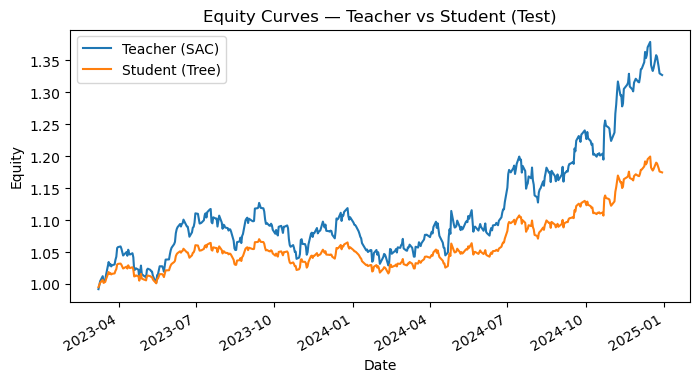

Fidelity (MAE of weights, test): 0.0888


In [12]:

# Build a supervised dataset from TRAIN period using the teacher actions
if model is not None:
    # Rollout teacher on train to get actions for imitation
    W_train_teacher, _, _ = rollout_policy(train_env, sac_policy_fn(model))
else:
    W_train_teacher, _, _ = rollout_policy(train_env, cash_only_policy(train_env))

aligned = train_feats.join(W_train_teacher, how="inner")
X_train = aligned[train_feats.columns].values
Y_train = aligned[W_train_teacher.columns].values
    
#X_train = train_feats.values
#Y_train = W_train_teacher.values  # multi-output: weights for each risky asset

# Fit a shallow tree for interpretability
tree = DecisionTreeRegressor(max_depth=3, random_state=SEED)
tree.fit(X_train, Y_train)

# Evaluate fidelity on TRAIN (how well the tree matches teacher weights)
Y_pred_train = tree.predict(X_train)
fidelity_mae = mean_absolute_error(Y_train, Y_pred_train)
print(f"Fidelity (MAE of weights, train): {fidelity_mae:.4f}")

# Student rollout on TEST
def tree_policy_fn(env):
    def fn(obs):
        w = tree.predict(np.array(obs, dtype=np.float32).reshape(1,-1))[0]
        # Map to logits approximately inverse-softmax by using log(w) with clipping; keep zero for cash
        w = np.clip(w, 0.0, 0.99)
        if w.sum() <= 0:
            return np.zeros(env.N, dtype=np.float32)
        logits = np.log(w + 1e-6)  # relative preferences; cash baseline 0
        logits = np.clip(logits, -5, 5)
        return logits.astype(np.float32)
    return fn

W_student, R_student, EQ_student = rollout_policy(test_env, tree_policy_fn(test_env))

# Compare equity curves
plt.figure()
EQ_teach.plot(label="Teacher (SAC)")
EQ_student.plot(label="Student (Tree)")
plt.title("Equity Curves — Teacher vs Student (Test)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.legend()
plt.show()

# Fidelity on TEST (compare weights when both are defined at the same timestamps)
aligned = W_teach.join(W_student, lsuffix="_T", rsuffix="_S")
mae_test = mean_absolute_error(aligned.filter(like="_T").values, aligned.filter(like="_S").values)
print(f"Fidelity (MAE of weights, test): {mae_test:.4f}")


# SHAP Feature Attribution for Student Tree

This cell analyzes the trained student tree using SHAP values for interpretability.

---

### 1. Aggregate Functions
- `aggregate_shap(shap_values)`:
  - Converts multi-output SHAP arrays into a 1D array for global feature importance.
  - Collapses all extra axes and averages absolute contributions across outputs.
- `aggregate_single(sv_example)`:
  - Aggregates SHAP values for a single observation (per-period importance).
  - Useful to explain decisions at a particular time step.

### 2. Initialize Explainer
- `TreeExplainer(tree)` is used for fast and reliable SHAP computation on tree models.
- A background sample (`X_bg`) is used for speed.

### 3. Global Feature Importance
- `shap_values` computed on the background sample.
- Aggregated to `abs_mean`.
- Top 20 features by absolute mean SHAP values are plotted as a bar chart.

### 4. Per-Period (Local) Explanation
- Pick the last test point (`x_example`) to inspect per-period importance.
- `sv_example` computed via the explainer.
- Aggregated absolute contributions are plotted for the top 15 features.
- This shows which features most influenced the student tree's last decision.


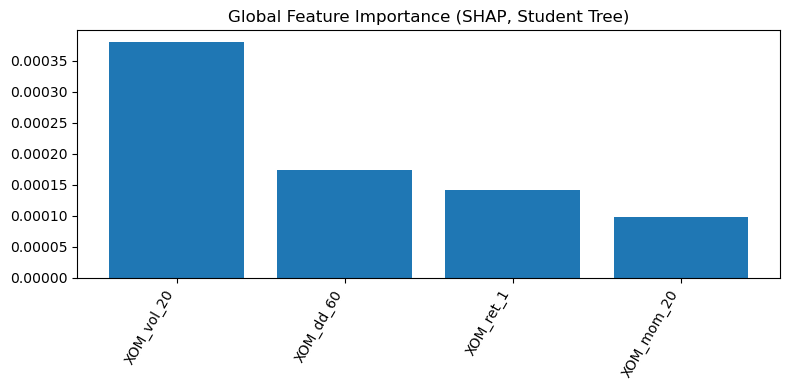

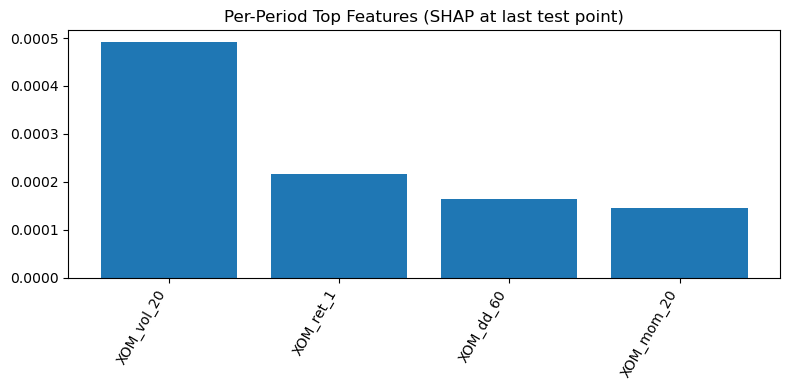

In [13]:
def aggregate_shap(shap_values):
    """Aggregate SHAP values to a 1D array (n_features,) for global importance."""
    if isinstance(shap_values, list):
        arrs = []
        for sv in shap_values:
            sv = np.array(sv)
            # collapse all but last axis (features)
            if sv.ndim > 2:
                sv = sv.reshape(-1, sv.shape[-1])
            arrs.append(np.abs(sv).mean(axis=0))
        return np.mean(arrs, axis=0)
    else:
        sv = np.array(shap_values)
        if sv.ndim > 2:
            sv = sv.reshape(-1, sv.shape[-1])
        return np.abs(sv).mean(axis=0)

def aggregate_single(sv_example):
    """Aggregate SHAP values for a single row (per-period importance)."""
    if isinstance(sv_example, list):
        arrs = []
        for s in sv_example:
            s = np.array(s)
            if s.ndim > 2:
                # collapse all except last axis (features)
                s = s.reshape(-1, s.shape[-1])
            # now take mean across all "samples" (outputs) for that row
            arrs.append(np.abs(s).mean(axis=0))
        return np.mean(arrs, axis=0)
    else:
        sv = np.array(sv_example)
        if sv.ndim > 2:
            sv = sv.reshape(-1, sv.shape[-1])
        return np.abs(sv).mean(axis=0)


 # --- Explainer ---
explainer = shap.TreeExplainer(tree)

# --- Background sample for speed ---
X_bg = X_train[np.random.choice(len(X_train), size=min(256, len(X_train)), replace=False)]

# --- Global feature importance ---
shap_values = explainer.shap_values(X_bg)
abs_mean = aggregate_shap(shap_values)

n_top = min(20, len(abs_mean))  # safe slicing
order = np.argsort(-abs_mean)[:n_top]
names = np.array(train_feats.columns)[order]
vals = abs_mean[order]

plt.figure()
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(vals)), names, rotation=60, ha="right")
plt.title("Global Feature Importance (SHAP, Student Tree)")
plt.tight_layout()
plt.show()

# --- Per-period explanation (last test point) ---
x_example = test_feats.values[-1].reshape(1, -1)
sv_example = explainer.shap_values(x_example)
sv_abs = aggregate_single(sv_example)

n_top_e = min(15, len(sv_abs))  # safe slicing
order_e = np.argsort(-sv_abs)[:n_top_e]
names_e = np.array(test_feats.columns)[order_e]
vals_e = sv_abs[order_e]

plt.figure()
plt.bar(range(len(vals_e)), vals_e)
plt.xticks(range(len(vals_e)), names_e, rotation=60, ha="right")
plt.title("Per-Period Top Features (SHAP at last test point)")
plt.tight_layout()
plt.show()

# Interpret Student Tree Rules

This cell extracts and prints the decision rules learned by the shallow student tree.

---

### 1. `export_text` function
- Converts a trained `DecisionTreeRegressor` into a human-readable text format.
- Shows each split condition, threshold, and predicted output at leaves.

### 2. Feature Names
- We pass `train_feats.columns` to label the tree splits with meaningful feature names.

### 3. Purpose
- Provides an interpretable summary of how the student tree approximates the teacher policy.
- Useful for understanding which features drive portfolio weight decisions.


In [14]:
rules = export_text(tree, feature_names=list(train_feats.columns))
print(rules)


|--- TSLA_mom_20 <= 0.43
|   |--- IEF_mom_20 <= -0.01
|   |   |--- IEF_mom_20 <= -0.03
|   |   |   |--- value: [0.19, 0.19, 0.23, 0.19]
|   |   |--- IEF_mom_20 >  -0.03
|   |   |   |--- value: [0.19, 0.19, 0.21, 0.20]
|   |--- IEF_mom_20 >  -0.01
|   |   |--- IEF_mom_20 <= 0.01
|   |   |   |--- value: [0.20, 0.19, 0.21, 0.20]
|   |   |--- IEF_mom_20 >  0.01
|   |   |   |--- value: [0.20, 0.20, 0.20, 0.20]
|--- TSLA_mom_20 >  0.43
|   |--- IEF_dd_60 <= -0.01
|   |   |--- TSLA_ret_1 <= -0.01
|   |   |   |--- value: [0.20, 0.19, 0.21, 0.21]
|   |   |--- TSLA_ret_1 >  -0.01
|   |   |   |--- value: [0.20, 0.20, 0.19, 0.22]
|   |--- IEF_dd_60 >  -0.01
|   |   |--- TSLA_mom_20 <= 0.69
|   |   |   |--- value: [0.20, 0.20, 0.18, 0.22]
|   |   |--- TSLA_mom_20 >  0.69
|   |   |   |--- value: [0.21, 0.20, 0.16, 0.24]



# Comparison with a Simple 60/40 Baseline

This cell compares the teacher, student, and a simple 60/40 equity/treasury benchmark.

---

### 1. 60/40 Baseline
- Uses only SPY (equities) and IEF (treasuries); gold is excluded.
- Fixed weights: 60% equities, 40% treasuries.
- Daily rebalanced.
- Computes cumulative equity curve for reference.

### 2. Equity Curve Comparison
- Plots the equity curves of:
  - Teacher policy (SAC)
  - Student policy (Decision Tree)
  - 60/40 baseline
- Provides a visual comparison of performance.

### 3. Summary Table
- Displays final equity values for each strategy.
- Includes test fidelity (MAE between teacher and student weights).
- Offers a quick quantitative comparison between strategies.


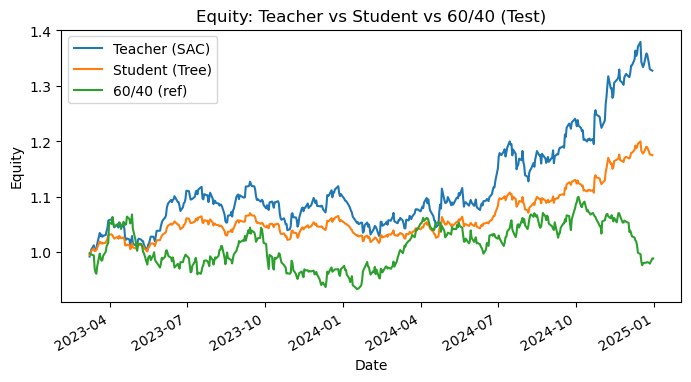

,Teacher_Final_Equity,Student_Final_Equity,Ref_60_40_Final_Equity,Fidelity_MAE_Test
0,1.327182,1.174871,0.988699,0.088824


In [15]:

# Simple 60/40 proxy for reference; rebalance daily.
def baseline_60_40(fwd_rets_df):
    w = np.array([0.6, 0.4] + [0.0]*(fwd_rets_df.shape[1]-2))
    r = (fwd_rets_df.values * w).sum(axis=1)
    eq = (1.0 + pd.Series(r, index=fwd_rets_df.index)).cumprod()
    return eq

EQ_6040 = baseline_60_40(test_fwd)

plt.figure()
EQ_teach.plot(label="Teacher (SAC)")
EQ_student.plot(label="Student (Tree)")
EQ_6040.plot(label="60/40 (ref)")
plt.title("Equity: Teacher vs Student vs 60/40 (Test)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.legend()
plt.show()

summary = pd.DataFrame({
    "Teacher_Final_Equity": [EQ_teach.iloc[-1]],
    "Student_Final_Equity": [EQ_student.iloc[-1]],
    "Ref_60_40_Final_Equity": [EQ_6040.iloc[-1]],
    "Fidelity_MAE_Test": [mae_test]
})
summary



## Notes & Next Steps
- **Speed knobs:** reduce `total_timesteps`, or pre-train and ship weights.
- **State stacking:** use rolling windows or LSTM policy for longer context.
- **Risk integrity:** expose reward components (costs, risk) in logs for audit.
- **Counterfactuals:** perturb a few top SHAP features and re-run the student to see action flips.
- **Fidelity at risk:** track fidelity as a monitored metric alongside PnL.

---

**Attribution caveat:** We run SHAP on the **student tree** for clarity and speed.
It’s a proxy for the teacher's rationale; always sanity-check with **counterfactuals** or permutation tests.
